In [175]:
import numpy as np
import TensorFrost as tf

tf.initialize(tf.opengl)

dt = 0.0001

def Force(x1, x2, v1, v2, rho):
    dx = x2 - x1
    dv = v2 - v1
    N = dx.shape[0]
    #dist = tf.norm(dx)
    #dist = tf.reshape(dist, [N, N, 1])
    i, j, k = dx.indices
    dX, dY, dZ = dx[i,j,0], dx[i,j,1], dx[i,j,2]
    dist = tf.sqrt(dX ** 2.0 + dY ** 2.0 + dZ ** 2.0)
    dvdotdx = dX * dv[i,j,0] + dY * dv[i,j,1] + dZ * dv[i,j,2]
    weight = tf.exp(-dist / 0.015)
    pressure = 0.2 * (rho[i] + rho[j])**2.0 * weight
    Fij = 0.2 * dx / (dist ** 3.0 + 5e-4)# + 100.0 * dvdotdx * dx * weight / (dist*dist + 1e-5)  - 50.0 * pressure * dx / (dist*dist + 1e-5)
    Fij = tf.select(i == j, 0.0, Fij)
    return Fij

def Density(x1, x2):
    dx = x2 - x1
    N = dx.shape[0]
    i, j = tf.indices([N, N])
    dX, dY, dZ = dx[i,j,0], dx[i,j,1], dx[i,j,2]
    dist = tf.sqrt(dX ** 2.0 + dY ** 2.0 + dZ ** 2.0)
    weight = tf.exp(-dist / 0.015)
    rho = 1.0 * weight
    return rho

def n_body():
    X = tf.input([-1, 3], tf.float32)
    N = X.shape[0]
    V = tf.input([N, 3], tf.float32)

    Xi = tf.reshape(X, [N, 1, 3])
    Vi = tf.reshape(V, [N, 1, 3])
    Xj = tf.reshape(X, [1, N, 3])
    Vj = tf.reshape(V, [1, N, 3])

    rho = tf.sum(Density(Xi, Xj), axis=1)

    Fi = tf.sum(Force(Xi, Xj, Vi, Vj, rho), axis=1)

    Vnew = V + Fi * dt
    Xnew = X + Vnew * dt

    return [Xnew, Vnew]

nbody = tf.compile(n_body)

n_body:
  Kernel count: 1
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 416
  IR Compile time: 2.667500 ms
  Compiler time: 1303.597412 ms



In [176]:

class vec3:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    
    def zero(shape):
        return vec3(tf.zeros(shape, tf.float32), tf.zeros(shape, tf.float32), tf.zeros(shape, tf.float32))
    
    def zero_like(val):
        return vec3.zero(val.x.shape)
    
    def const(val, shape):
        return vec3(tf.const(val, shape), tf.const(val, shape), tf.const(val, shape))
    
    def copy(val):
        vec = vec3.zero(val.x.shape)
        vec.set(val)
        return vec
    
    def set(self, other):
        self.x.val = other.x
        self.y.val = other.y
        self.z.val = other.z
    
    def __add__(self, other):
        return vec3(self.x + other.x, self.y + other.y, self.z + other.z)
    
    def __radd__(self, other):
        return vec3(other.x + self.x, other.y + self.y, other.z + self.z)
    
    def __sub__(self, other):
        return vec3(self.x - other.x, self.y - other.y, self.z - other.z)
    
    def __rsub__(self, other):
        return vec3(other.x - self.x, other.y - self.y, other.z - self.z)
    
    def __mul__(self, other):
        return vec3(self.x * other, self.y * other, self.z * other)
    
    def __rmul__(self, other):
        return vec3(self.x * other, self.y * other, self.z * other)
    
    def __div__(self, other):
        return vec3(self.x / other, self.y / other, self.z / other)
    
    def __rdiv__(self, other):
        return vec3(other / self.x, other / self.y, other / self.z)
    
    def __truediv__(self, other):
        return vec3(self.x / other, self.y / other, self.z / other)
    
    def __neg__(self):
        return vec3(-self.x, -self.y, -self.z)
    
    def __abs__(self):
        return vec3(tf.abs(self.x), tf.abs(self.y), tf.abs(self.z))
    
    def __pow__(self, other):
        return vec3(self.x ** other, self.y ** other, self.z ** other)
    
    def __rpow__(self, other):
        return vec3(other ** self.x, other ** self.y, other ** self.z)

def mul(a, b):
    return vec3(a.x * b.x, a.y * b.y, a.z * b.z)

def dot(a, b):
    return a.x * b.x + a.y * b.y + a.z * b.z

def cross(a, b):
    return vec3(a.y * b.z - a.z * b.y, a.z * b.x - a.x * b.z, a.x * b.y - a.y * b.x)

def length(a):
    return tf.sqrt(dot(a, a))

def distance(a, b):
    return length(a - b)

def normalize(a):
    return a / (length(a) + 1e-5)

def min(a, b):
    return vec3(tf.min(a.x, b.x), tf.min(a.y, b.y), tf.min(a.z, b.z))

def max(a, b):
    return vec3(tf.max(a.x, b.x), tf.max(a.y, b.y), tf.max(a.z, b.z))

def clamp(a, low, high):
    return vec3(tf.clamp(a.x, low, high), tf.clamp(a.y, low, high), tf.clamp(a.z, low, high))

def exp(a):
    return vec3(tf.exp(a.x), tf.exp(a.y), tf.exp(a.z))

def lerp(a, b, t):
    return a + (b - a) * t

def abs(a):
    return vec3(tf.abs(a.x), tf.abs(a.y), tf.abs(a.z))

def reflect(i, n):
    return i - n * 2.0 * dot(n, i)

def sdBox(p, b):
    d = abs(p) - b
    return tf.min(tf.max(d.x, tf.max(d.y, d.z)), 0.0) + length(max(d, vec3(0.0, 0.0, 0.0)))

def mod(a, b):
    return vec3(tf.modf(a.x, b.x), tf.modf(a.y, b.y), tf.modf(a.z, b.z))

focal_length = 1.0

def project(p, camera):
    dpos = p - vec3(camera[0, 0], camera[0, 1], camera[0, 2])
    cam_f = vec3(camera[3, 0], camera[3, 1], camera[3, 2])
    cam_u = vec3(camera[2, 0], camera[2, 1], camera[2, 2])
    cam_v = vec3(camera[1, 0], camera[1, 1], camera[1, 2])
    nor = focal_length / dot(dpos, cam_f)
    u = dot(dpos, cam_u) * nor
    v = dot(dpos, cam_v) * nor
    z = dot(dpos, cam_f)
    return u, v, z

def render_particles():
    X = tf.input([-1, 3], tf.float32)
    N = X.shape[0]
    params = tf.input([2], tf.int32)
    camera = tf.input([4,3], tf.float32)

    ImageW = params[0]
    ImageH = params[1]
    atomic_canvas = tf.zeros([ImageH, ImageW], tf.int32)

    i, = tf.indices([N])

    min_res = tf.min(ImageW, ImageH)

    def uv_to_ij(u, v):
        i = v * tf.float(min_res) + 0.5 * tf.float(ImageH)
        j = u * tf.float(min_res) + 0.5 * tf.float(ImageW)
        return i, j

    def render_particle(x, y, z):
        u, v, z = project(vec3(x, y, z), camera)
        i, j = uv_to_ij(u, v)

        is_inside = (i >= 0.0) & (i < tf.float(ImageH)) & (j >= 0.0) & (j < tf.float(ImageW)) & (z > 0.0)


        rad = tf.clamp(1/(z + 1e-4), 1.0, 20.0)
        intensity = 10 / (rad * rad)

        with tf.if_cond(is_inside):
            xi = tf.int(i)
            yi = tf.int(j)
            xf = i - tf.float(xi)
            yf = j - tf.float(yi)
            radius = tf.ceil(rad)
            with tf.loop(-radius, radius + 1) as ii:
                with tf.loop(-radius, radius + 1) as jj:
                    dx = tf.float(ii) - xf
                    dy = tf.float(jj) - yf
                    dist = tf.sqrt(dx ** 2.0 + dy ** 2.0)
                    weight = tf.exp(-(dist / float(rad)) ** 2.0)
                    tf.scatterAdd(atomic_canvas[xi + ii, yi + jj], tf.int(intensity * weight))

    render_particle(X[i, 0], X[i, 1], X[i, 2])

    i, j, ch = tf.indices([ImageH, ImageW, 3])
    image = tf.float(atomic_canvas[i, j]) / 100.0
    return [image]

render = tf.compile(render_particles)

render_particles:
  Kernel count: 3
  Intermediate buffers: 1
  Host readbacks: 2
  Host writes: 0
  Lines of generated code: 419
  IR Compile time: 4.134000 ms
  Compiler time: 1274.098389 ms



In [177]:
def normalize(v):
    """Normalize a vector."""
    norm = np.linalg.norm(v)
    return v / norm if norm > 0 else v

def quaternion_multiply(q1, q2):
    """Multiply two quaternions."""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 + y1*w2 + z1*x2 - x1*z2
    z = w1*z2 + z1*w2 + x1*y2 - y1*x2
    return np.array([w, x, y, z])

def quaternion_to_matrix(q):
    """Convert a quaternion into a rotation matrix."""
    w, x, y, z = q
    return np.array([
        [1 - 2*y*y - 2*z*z,     2*x*y - 2*z*w,     2*x*z + 2*y*w],
        [    2*x*y + 2*z*w, 1 - 2*x*x - 2*z*z,     2*y*z - 2*x*w],
        [    2*x*z - 2*y*w,     2*y*z + 2*x*w, 1 - 2*x*x - 2*y*y]
    ])

def axis_angle_quaternion(axis, angle):
    """Create a quaternion from an axis and an angle."""
    axis = normalize(axis)
    angle /= 2
    return np.array([np.cos(angle), axis[0] * np.sin(angle), axis[1] * np.sin(angle), axis[2] * np.sin(angle)])

class Camera:
    def __init__(self, position, quaternion):
        self.position = np.array(position, dtype=np.float32)
        self.quaternion = np.array(quaternion, dtype=np.float32)

    def axis(self, axis):
        return quaternion_to_matrix(self.quaternion)[axis, :]

    def move_axis(self, axis, distance):
        self.position += normalize(self.axis(axis)) * distance

    def rotate_axis(self, axis, angle):
        self.quaternion = quaternion_multiply(self.quaternion, axis_angle_quaternion(self.axis(axis), angle))
    
    def get_camera_matrix(self):
        """Get the camera matrix."""
        return np.stack([self.position, *quaternion_to_matrix(self.quaternion)])

In [203]:
ParticleN = 20000

X = np.random.randn(ParticleN, 3).astype(np.float32) * IC_Radius
#V = np.zeros([N, 2], np.float32)
#initialize with rotation
V = np.zeros([ParticleN, 3], np.float32)
V[:, 0] = -X[:, 1] * 300.1
V[:, 1] = X[:, 0] * 300.1

#
#DistrRadius = 2.0
#PlanetRadius = 2.0
#
##make 2 planets
#planet1N = ParticleN // 2
#planet2N = ParticleN - planet1N
#
#planet1Pos = np.random.randn(3).astype(np.float32) * DistrRadius
#planet2Pos = np.random.randn(3).astype(np.float32) * DistrRadius
#
##make them orbit each other
#center = (planet1Pos + planet2Pos) / 2.0
#planet1Pos -= center
#planet2Pos -= center
#
#randomRotVec = np.random.randn(3).astype(np.float32)
#randomRotVec /= np.linalg.norm(randomRotVec)
#randomRotVec *= 0.5
#
#planet1Vel = 20.0*np.cross(randomRotVec, planet1Pos)
#planet2Vel = 20.0*np.cross(randomRotVec, planet2Pos)
#
#X = np.zeros([ParticleN, 3], np.float32)
#V = np.zeros([ParticleN, 3], np.float32)
#
#X[:planet1N] = np.random.randn(planet1N, 3).astype(np.float32) * PlanetRadius + planet1Pos
#X[planet1N:] = np.random.randn(planet2N, 3).astype(np.float32) * PlanetRadius + planet2Pos
#
#V[:planet1N] = planet1Vel
#V[planet1N:] = planet2Vel

Xtf = tf.tensor(X)
Vtf = tf.tensor(V)

In [204]:
import time

ImageW = 1280
ImageH = 800

tf.show_window(ImageW, ImageH, "N-body simulation")

camera = Camera([0, 0, -6], axis_angle_quaternion([0, 0, 1], -np.pi/2))
pmx, pmy = tf.get_mouse_position()

angular_speed = 0.005
camera_speed = 0.1
prev_cam_mat = camera.get_camera_matrix()
frame_id = 0

accum = 0.95
fractal_angle = np.pi / 7.5
fractal_scale = 0.72
bounces = 3

prev_time = time.time()
smooth_delta_time = 0.0

while not tf.window_should_close():
    mx, my = tf.get_mouse_position()
    cur_time = time.time()

    delta_time = cur_time - prev_time
    smooth_delta_time = 0.9 * smooth_delta_time + 0.1 * delta_time

    if tf.is_mouse_button_pressed(tf.MOUSE_BUTTON_0):
        camera.rotate_axis(0, (mx - pmx) * angular_speed)
        camera.rotate_axis(1, (my - pmy) * angular_speed)

    if tf.is_key_pressed(tf.KEY_W):
        camera.move_axis(2, camera_speed)
    if tf.is_key_pressed(tf.KEY_S):
        camera.move_axis(2, -camera_speed)

    if tf.is_key_pressed(tf.KEY_A):
        camera.move_axis(1, -camera_speed)
    if tf.is_key_pressed(tf.KEY_D):
        camera.move_axis(1, camera_speed)

    if tf.is_key_pressed(tf.KEY_Q):
        camera.rotate_axis(2, angular_speed*2)
    if tf.is_key_pressed(tf.KEY_E):
        camera.rotate_axis(2, -angular_speed*2)

    ImageW, ImageH = tf.get_window_size()
    time_tf = tf.tensor(np.array([cur_time], np.float32))
    Xtf, Vtf = nbody(Xtf, Vtf)
    params = tf.tensor(np.array([ImageW, ImageH], np.int32))
    cam_mat = camera.get_camera_matrix()
    cam_mat_tf = tf.tensor(cam_mat)
    frame_tf, = render(Xtf, params, cam_mat_tf)
    tf.render_frame(frame_tf)
    tf.imgui_text("Simulation time: %.3f ms" % (1000.0 * smooth_delta_time))
    tf.imgui_text("Particles: %d" % ParticleN)
    tf.imgui_text("FPS: %.1f" % (1.0 / (smooth_delta_time + 1e-5)))
    tf.imgui_text("Time step: %.3f" % dt)
    
    pmx, pmy = mx, my
    prev_cam_mat = cam_mat
    frame_id += 1
    prev_time = cur_time

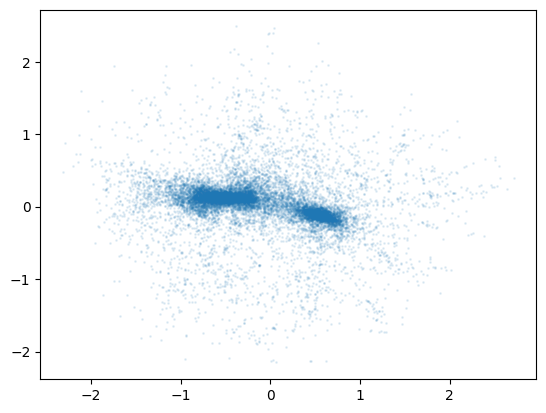

In [180]:
#plot the particles
from matplotlib import pyplot as plt

X = Xtf.numpy
plt.scatter(X[:, 1], X[:, 2], s=1, alpha=0.1)
plt.show()
